In [1]:
"""
@author: Yongji Wang, Yao Lai, Ray Chou (modified from Maziar Raissi)
"""
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(123)
tf.random.set_seed(123)

print(tf.__version__)

2.5.0


In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.nu = nu
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be 
        #            automatically updated in the original tf.Variable
        
        # define the loss function
        self.loss = self.loss_NN()
        
    
    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''
                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''
    
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    
    def net_f(self, x,t):
        u = self.net_u(x,t)        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + u*u_x - self.nu*u_xx
        return f
    
    
    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.u_pred = self.net_u(self.x_u, self.t_u) 
        self.f_pred = self.net_f(self.x_f, self.t_f)      
        loss = tf.reduce_mean(tf.square(self.u - self.u_pred)) + \
               tf.reduce_mean(tf.square(self.f_pred))
        return loss
    
    
    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''
    
    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self):
        # obtain the shapes of all trainable parameters in the model
        varlist = self.train_variables
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)
    
        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = [] # stitch indices
        part = [] # partition indices
        
        self.start_time = time.time()
    
        for i, shape in enumerate(shapes):
            n = np.product(shape)
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            part.extend([i]*n)
            count += n
    
        part = tf.constant(part)
        
        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self
            
            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                self.train_variables[i].assign(tf.reshape(param, shape))
                
                
        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self
    
            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model 
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_value = self.loss_NN()
    
            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_value, varlist)
            grads = tf.dynamic_stitch(idx, grads)
    
            # store loss value so we can retrieve later
            tf.py_function(f.history.append, inp=[loss_value], Tout=[])
                
            # print out iteration & loss
            f.iter.assign_add(1)
            
            if f.iter % 10 == 0:
                tf.print("Iter:", f.iter, "loss:", loss_value)
                
            return loss_value, grads
        
        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.history = []
        
        return f
    
    
    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter):
        
        func = self.Lbfgs_function()
    
        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, self.train_variables)
        
        max_nIter = tf.cast(nIter/3, dtype = tf.int32)
    
        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, max_iterations=max_nIter)
    
        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)
        
        
    '''
    Function used for training the model
    ===============================================================
    '''
        
    def train(self, nIter):
        # running the Lbfgs optimization
        self.Lbfgs_optimizer(nIter)
            
        
    @tf.function
    def predict(self, X_star):
        u_star = self.net_u(X_star[:,0:1], X_star[:,1:2])  
        f_star = self.net_f(X_star[:,0:1], X_star[:,1:2])                 
        return u_star, f_star

In [11]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))   #x,t coordinates of the training data at t=0
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))       #x,t coordinates of the training data at x=1
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))       #x,t coordinates of the training data at x=-1
uu3 = Exact[:,-1:]
  
X_u_train = np.vstack([xx1, xx2, xx3])      #x,t coordinates of all training data at t=0, x=1, x=-1
X_f_train = lb + (ub-lb)*lhs(2, N_f)  
X_f_train = np.vstack((X_f_train, X_u_train))

In [12]:
X_f_train.shape

(10456, 2)

In [13]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))   #x,t coordinates of the training data at t=0
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))       #x,t coordinates of the training data at x=1
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))       #x,t coordinates of the training data at x=-1
uu3 = Exact[:,-1:]
  
X_u_train = np.vstack([xx1, xx2, xx3])      #x,t coordinates of all training data at t=0, x=1, x=-1
X_f_train = lb + (ub-lb)*lhs(2, N_f)        #x,t coordinates of all collocation points
#X_f_train = np.vstack((X_f_train, X_u_train))  #this was in raissi (2019) but seems redundant
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)

model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

start_time = time.time()                
model.train(5000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     


U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Iter: 10 loss: 0.238641411
Iter: 20 loss: 0.193053693
Iter: 30 loss: 0.182944566
Iter: 40 loss: 0.154447138
Iter: 50 loss: 0.114991091
Iter: 60 loss: 0.106289737
Iter: 70 loss: 0.104233503
Iter: 80 loss: 0.102444962
Iter: 90 loss: 0.0981122926
Iter: 100 loss: 0.0973370224
Iter: 110 loss: 0.11765869
Iter: 120 loss: 0.0960384235
Iter: 130 loss: 0.0943683
Iter: 140 loss: 0.0930638
Iter: 150 loss: 0.0923197716
Iter: 160 loss: 0.0918155462
Iter: 170 loss: 0.0918608308
Iter: 180 loss: 0.09049806
Iter: 190 loss: 0.0912348
Iter: 200 loss: 0.0872942954
Iter: 210 loss: 0.0903080925
Iter: 220 loss: 0.0833502
Iter: 230 loss: 0.0823828131
Iter: 240 loss: 0.0805845261
Iter: 250 loss: 0.0794765428
Iter: 260 loss: 0.0776305944
Iter: 270 loss: 0.0767484456
Iter: 280 loss: 0.0747122839
Iter: 290 loss: 0.0727537647
Iter: 300 loss: 0.0693247318
Iter: 310 loss: 0.0676396936
Iter: 320 loss: 0.0666257367
Iter: 330 loss: 0.0655220449
Iter: 340 loss: 0.0665814
Iter: 350 loss: 0.0646372
Iter: 360 loss: 0.064927

Iter: 2770 loss: 0.00303196954
Iter: 2780 loss: 0.00300958287
Iter: 2790 loss: 0.00298379408
Iter: 2800 loss: 0.00297161099
Iter: 2810 loss: 0.0029541289
Iter: 2820 loss: 0.00293923775
Iter: 2830 loss: 0.00293110125
Iter: 2840 loss: 0.0029120422
Iter: 2850 loss: 0.00290038693
Iter: 2860 loss: 0.00288391067
Iter: 2870 loss: 0.00286362157
Iter: 2880 loss: 0.00283079874
Iter: 2890 loss: 0.00282291556
Iter: 2900 loss: 0.00281512085
Iter: 2910 loss: 0.00282865157
Iter: 2920 loss: 0.00279675703
Iter: 2930 loss: 0.00277472939
Iter: 2940 loss: 0.00274358317
Iter: 2950 loss: 0.00271825679
Iter: 2960 loss: 0.00270874822
Iter: 2970 loss: 0.00269235414
Iter: 2980 loss: 0.00268233125
Iter: 2990 loss: 0.00265877089
Iter: 3000 loss: 0.00263177184
Iter: 3010 loss: 0.00264879549
Iter: 3020 loss: 0.00261100428
Iter: 3030 loss: 0.00258306367
Iter: 3040 loss: 0.00256879022
Iter: 3050 loss: 0.00255440618
Iter: 3060 loss: 0.00253591547
Iter: 3070 loss: 0.00253276085
Iter: 3080 loss: 0.00249969959
Iter: 3090

Text(0.5, 1.0, '$t = 0.75$')

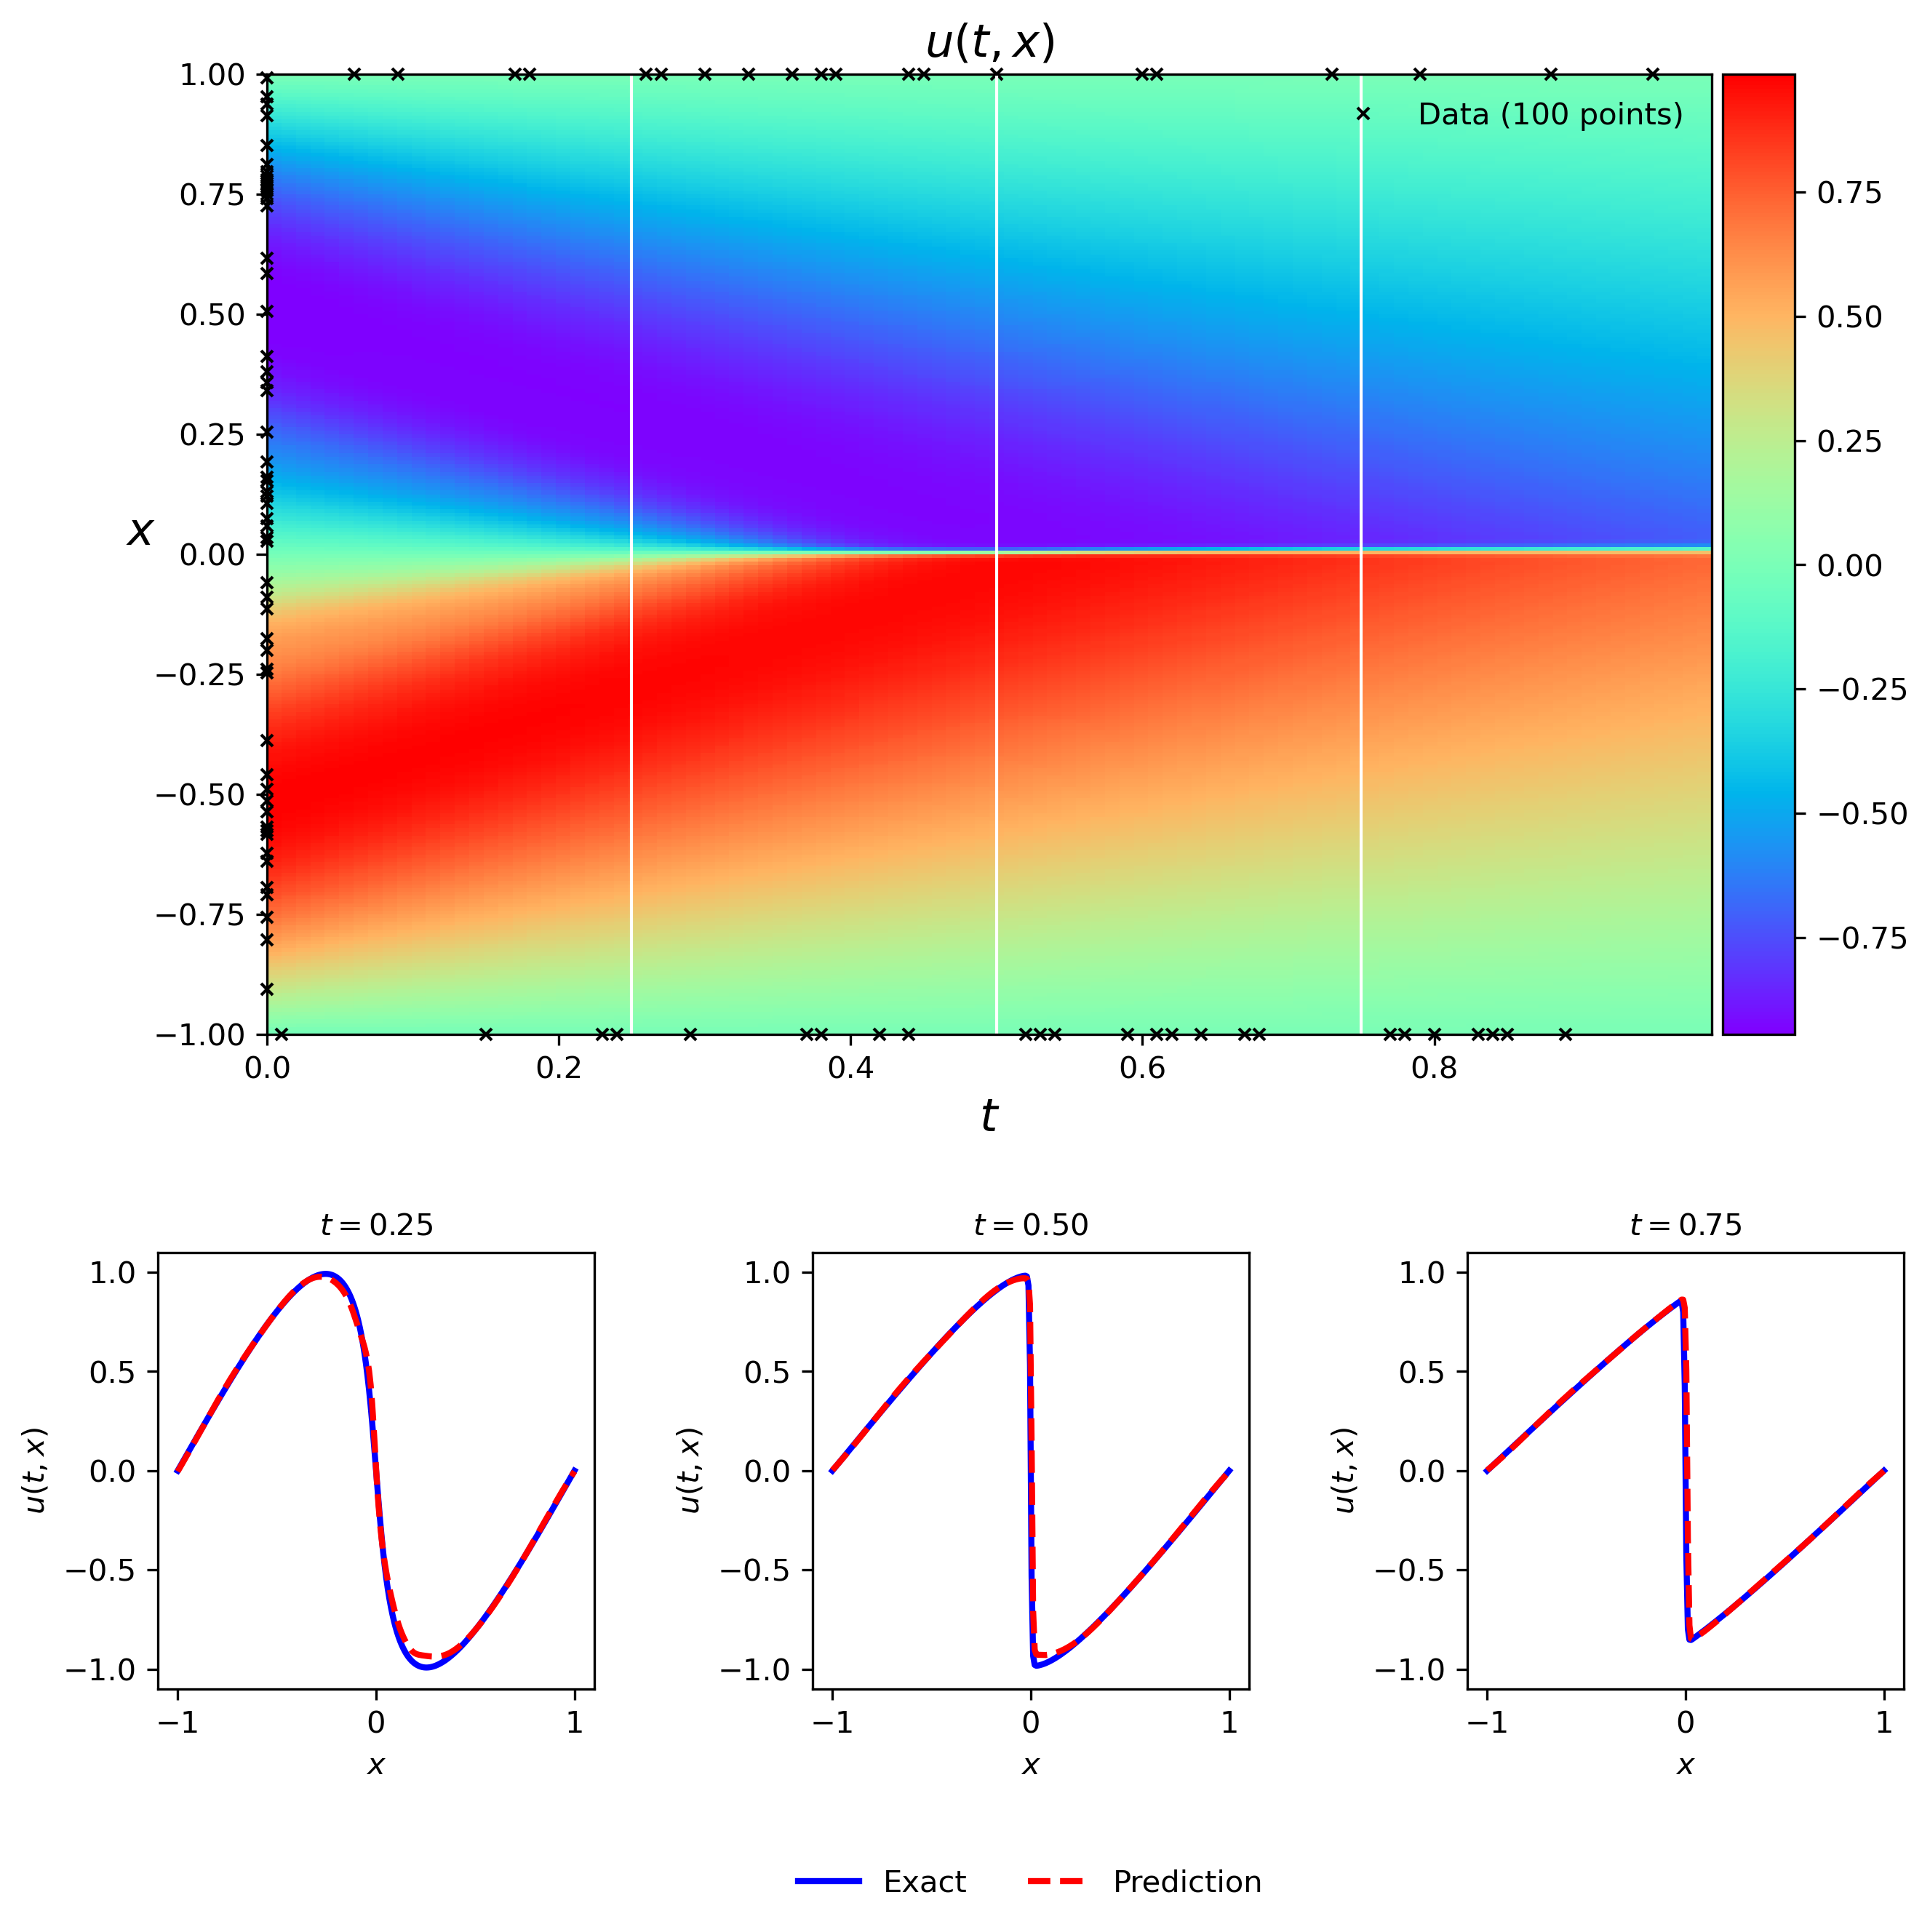

In [14]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    

fig = plt.figure(figsize = [10, 10], dpi = 300)

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    


ax.set_xlabel('$t$', fontsize = 15)
ax.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax.set_title('$u(t,x)$', fontsize = 15)
ax.legend(frameon=False, loc = 'best')

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/2, bottom=0.1, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)